In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Forecasting using Prophet

### Installation

In [1]:
!pip install statsmodels --quiet
!pip install fbprophet --quiet

In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from fbprophet import Prophet

In [3]:
cd ..

/kaggle


In [4]:
ls

input/  lib/  working/


### Data preparation

In [13]:
df = pd.read_csv('input/arsenal-data/prem-arsenal.csv')
df_1 = df.iloc[:38,:]
df_2 = df.iloc[38:2*(38),:]
df_3 = df.iloc[2*(38):3*(38):]
df.columns

Index(['date_col', 'home', 'away', 'score', 'points', 'home-adv', 'referee'], dtype='object')

In [14]:
df_1['cum_pts'] = df_1.points.cumsum()
df_2['cum_pts'] = df_2.points.cumsum()
df_3['cum_pts'] = df_3.points.cumsum()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [15]:
df_table = pd.DataFrame()
df_table = df_table.append(df_1)
df_table = df_table.append(df_2)
df_table = df_table.append(df_3)
df_table = pd.get_dummies(df_table, columns=['referee'])

In [16]:
df_s = df_table.copy()
df_s['date_col'] = pd.to_datetime(df_s['date_col'])
df_s = df_s.set_index('date_col')
df_s.index = pd.date_range(start='15/08/2018', periods=df_s.shape[0], freq='W')
s=seasonal_decompose(df_s['cum_pts'])

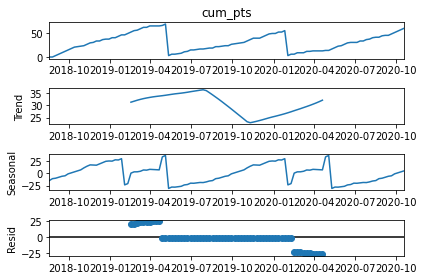

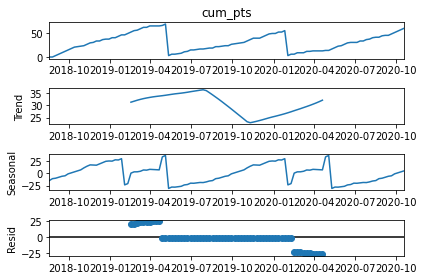

In [17]:
s.plot()

### Modelling

#### Without regressors

In [ ]:
df_t = df_table[['date_col','cum_pts',]]
df_t.columns = ["ds", "y"]

In [ ]:
df_table.index = df_table['date_col']
df_table['cum_pts'].plot(figsize=(10, 8))

In [ ]:
df_table.columns

In [ ]:
m = Prophet(seasonality_mode='multiplicative')
m.fit(df_t)

In [ ]:
pred_df = pd.DataFrame()
pred_df['ds'] = pd.date_range(start='13/08/2021', periods=5, freq='W')


In [ ]:
preds = m.predict(pred_df)
preds['yhat'] = [int(x) for x in preds['yhat']]

In [ ]:
pred_df['cum_pts_preds'] = preds['yhat']
pred_df.head()

In [ ]:
pred_df.index = pred_df['ds']
pred_df['cum_pts_preds'].plot()

#### with home-advantage

In [78]:
df_t = df_table[['date_col','cum_pts', 'home-adv']]
df_t.columns = ["ds", "y", "home-adv"]

<AxesSubplot:xlabel='date_col'>

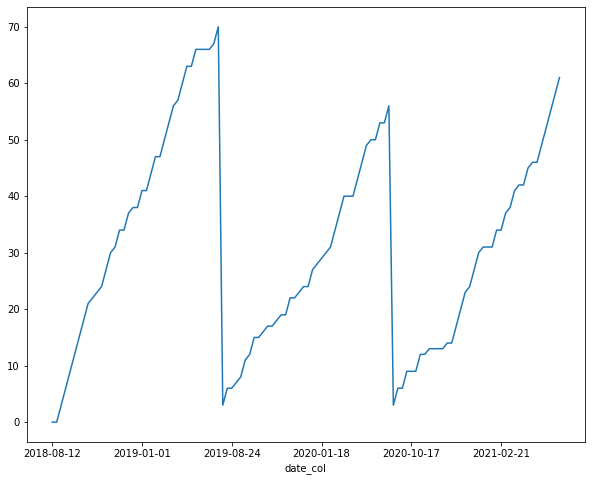

In [79]:
df_table.index = df_table['date_col']
df_table['cum_pts'].plot(figsize=(10, 8))

In [80]:
m = Prophet(seasonality_mode='multiplicative')
m.add_regressor('home-adv')
m.fit(df_t)

In [98]:
import random
my_list = [0]*19 + [1]*19
random.shuffle(my_list)

In [99]:
pred_df = pd.DataFrame()
pred_df['ds'] = pd.date_range(start='13/08/2021', periods=38, freq='W')
pred_df['home-adv'] = my_list

In [100]:
preds = m.predict(pred_df)
preds['yhat'] = [int(x) for x in preds['yhat']]

pred_df['cum_pts_preds'] = preds['yhat']
pred_df.tail()

,ds,home-adv,cum_pts_preds
33,2022-04-03,1,58
34,2022-04-10,1,59
35,2022-04-17,1,61
36,2022-04-24,0,62
37,2022-05-01,0,64


<AxesSubplot:xlabel='ds'>

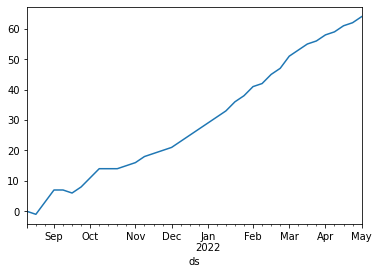

In [141]:
pred_df.index = pred_df['ds']
pred_df['cum_pts_preds'].plot()

#### with referees

In [ ]:
df_table.columns

In [ ]:
df_t = df_table[['date_col','cum_pts', 'home-adv', 'referee_Anthony Taylor',
                 'referee_Jonathan Moss', 'referee_Martin Atkinson',
                 'referee_Michael Oliver', 'referee_Mike Dean']]

df_t.columns = ["ds", "y", "home-adv",'referee_Anthony Taylor', 
                'referee_Jonathan Moss','referee_Martin Atkinson', 
                'referee_Michael Oliver','referee_Mike Dean']

In [ ]:
m = Prophet(seasonality_mode='multiplicative')
m.add_regressor('home-adv')
m.add_regressor('referee_Anthony Taylor')
m.add_regressor('referee_Jonathan Moss')
m.add_regressor('referee_Martin Atkinson')
m.add_regressor('referee_Michael Oliver')
m.add_regressor('referee_Mike Dean')
m.fit(df_t)

In [ ]:
pred_df = pd.DataFrame()
pred_df['ds'] = pd.date_range(start='13/08/2021', periods=5, freq='W')
pred_df['home-adv'] = [0, 1, 0, 1, 1]
pred_df['referee_Anthony Taylor'] = [0, 1, 0, 0, 1]
pred_df['referee_Jonathan Moss'] = [0, 0, 1, 0, 0]
pred_df['referee_Martin Atkinson'] = [1, 0, 0, 0, 0]
pred_df['referee_Michael Oliver'] = [0, 0, 0, 1, 0]
pred_df['referee_Mike Dean'] = [0, 1, 0, 0, 0]

In [ ]:
preds = m.predict(pred_df)
preds['yhat'] = [int(x) for x in preds['yhat']]

pred_df['cum_pts_preds'] = preds['yhat']
pred_df.head()

In [ ]:
pred_df.index = pred_df['ds']
pred_df['cum_pts_preds'].plot()

## Validation data

<AxesSubplot:xlabel='ds'>

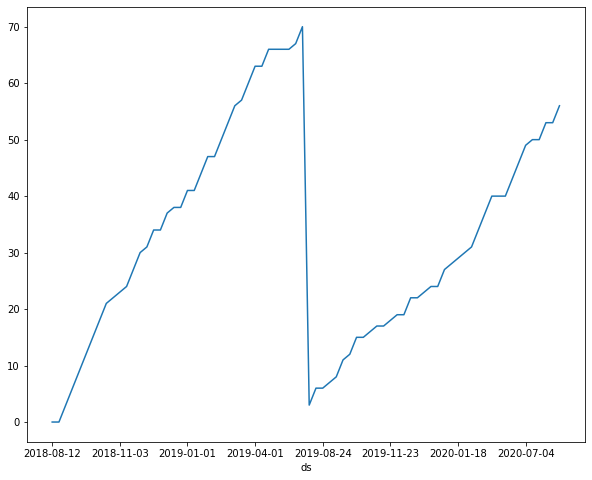

In [143]:
df_t = df_table[['date_col','cum_pts', 'home-adv']]
df_t.columns = ["ds", "y", "home-adv"]

dtrain, dvalid = df_t.iloc[:76,:], df_t.iloc[76:,:]
dtrain.index = dtrain['ds']
dtrain['y'].plot(figsize=(10, 8))

In [144]:
m = Prophet(seasonality_mode='multiplicative')
m.add_regressor('home-adv')
m.fit(dtrain)

In [145]:
preds = m.predict(dvalid[['ds','home-adv']])
preds['predictions'] = [int(x) for x in preds['yhat']]
dvalid['forecast'] = preds['predictions']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


<AxesSubplot:>

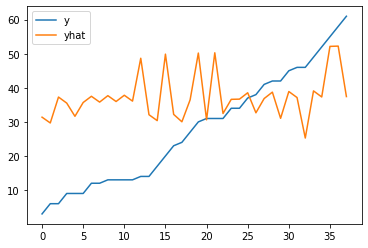

In [146]:
dvalid.index = preds.index
preds['yhat'] = [abs(x) for x in preds['yhat']]
preds['yhat_lower'] = [abs(x) for x in preds['yhat_lower']]
preds['yhat_upper'] = [abs(x) for x in preds['yhat_upper']]
dvalid[['yhat_lower', 'yhat_upper', 'yhat']] = preds[['yhat_lower', 'yhat_upper', 'yhat']]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Text(0, 0.5, 'Points')

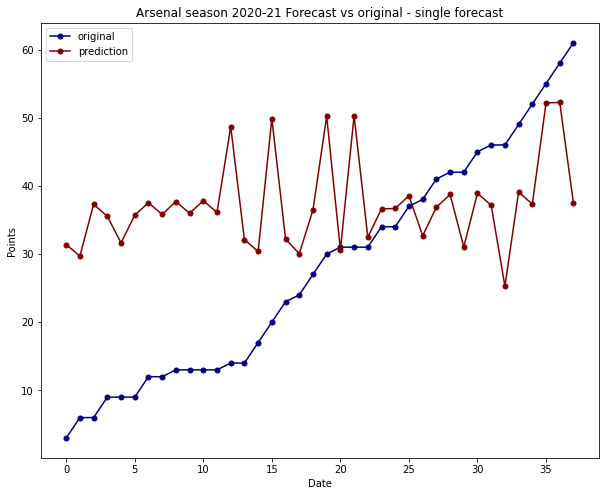

In [152]:
dvalid['original'] = dvalid['y']
dvalid['prediction'] = dvalid['yhat']
ax = dvalid[['original', 'prediction']].plot(figsize=(10,8), 
                                colormap='jet',marker='.', markersize=10, 
                             title='Arsenal season 2020-21 Forecast vs original - single forecast')

ax.set_xlabel("Date")
ax.set_ylabel("Points")

## Rolling prediction

In [67]:
dvalid.shape

(38, 3)

In [108]:
window = 7
pr_df = pd.DataFrame()

for i in range(0, int(dvalid.shape[0]/window)):
    roll_df = dvalid.iloc[i*(window):i*(window) + window,:]
    print(i)
    m1 = Prophet(seasonality_mode='multiplicative')
    m1.add_regressor('home-adv')
    m1.fit(dtrain)
    preds = m.predict(roll_df[['ds','home-adv']])
    dtrain = dtrain.append(roll_df)
    pr_df  = pr_df.append(preds)

0
1
2
3
4


In [132]:
dvalid.iloc[:pr_df.shape[0],:].index = pr_df.index
pr_df['yhat'] = [abs(x) for x in pr_df['yhat']]
pr_df['yhat_lower'] = [abs(x) for x in pr_df['yhat_lower']]
pr_df['yhat_upper'] = [abs(x) for x in pr_df['yhat_upper']]
dfinalv = dvalid.iloc[:pr_df.shape[0],:]
pr_df.index = pr_df['ds']
dfinalv.index = pr_df.index
dfinalv[['yhat_lower', 'yhat_upper', 'yhat']] = pr_df[['yhat_lower', 'yhat_upper', 'yhat']]

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Text(0, 0.5, 'Points')

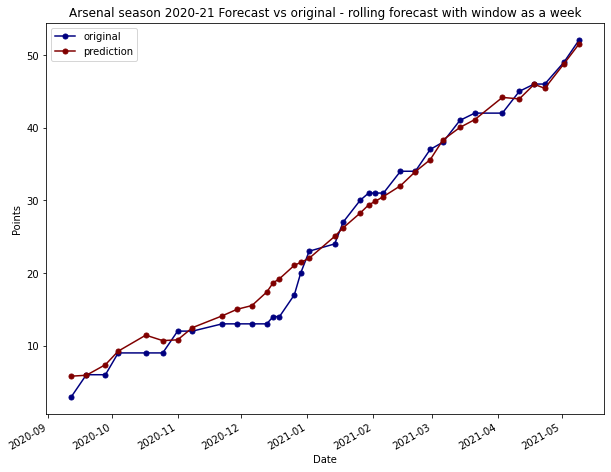

In [150]:
dfinalv['original'] = dfinalv['y']
dfinalv['prediction'] = dfinalv['yhat']
ax = dfinalv[['original', 'prediction']].plot(figsize=(10, 8), 
                            colormap='jet', 
                            marker='.', 
                            markersize=10, 
                            title='Arsenal season 2020-21 Forecast vs original - rolling forecast with window as a week')
ax.set_xlabel("Date")
ax.set_ylabel("Points")

In [130]:
pr_df.head(2)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,extra_regressors_multiplicative,extra_regressors_multiplicative_lower,extra_regressors_multiplicative_upper,home-adv,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
ds,,,,,,,,,,,,,,,,,,,,,
2020-09-12,2020-09-12,26.480809,2.945837,8.859549,26.480809,26.480809,0.000000,0.000000,0.000000,0.000000,...,0.019912,0.019912,0.019912,-0.800765,-0.800765,-0.800765,0.0,0.0,0.0,5.803193
2020-09-19,2020-09-19,26.424410,3.228570,9.037046,26.424410,26.424410,0.014717,0.014717,0.014717,0.014717,...,0.019912,0.019912,0.019912,-0.810364,-0.810364,-0.810364,0.0,0.0,0.0,5.926059


In [131]:
dfinalv.head(2)

,ds,y,home-adv,forecast,yhat_lower,yhat_upper,yhat
ds,,,,,,,
2020-09-12,2020-09-12,3,0,32,NaN,NaN,NaN
2020-09-19,2020-09-19,6,1,31,NaN,NaN,NaN
